In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


def animate(steps):

    def init():
        im.set_data(steps[0])

        return [im]

    def animate(i):
        im.set_data(steps[i])
        
        return [im]

    im = plt.matshow(steps[0], interpolation='None', animated=True)
    figure = im.get_figure()

    return FuncAnimation(figure, animate, init_func=init, frames=len(steps), interval=100, blit=True, repeat=False)


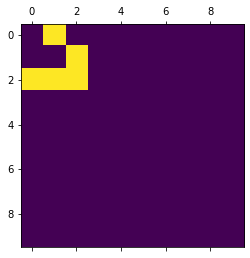

In [2]:
import random
from threading import Thread, Lock, Condition, Semaphore
from IPython.display import HTML

# number of row and columns for matrix
N = 10
# number of cells inside matrix
N_CELLS = N ** 2
# number of generations / iterations that will be runned
NUM_GEN = 200
# array of coordinates for initializing glider
glider_coords = [(0, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
# matrix of cells
cells = [[None for _ in range(N)] for _ in range(N)]
# matrix of states for each cell of each generation
states = [[0 for _ in range(N)] for _ in range(N)]
# array of states matrix for each generation
generations = [states]
# cell counter for tracking updated cells
cells_done = 0
# conditions and locks
generation_condition = Condition()
cells_done_lock = Lock()


class Cell(Thread):
    global N
    global N_CELLS
    global NUM_GEN
    global cells
    global states
    global generations
    global generation_condition
    global cells_done
    global cells_done_lock

    def __init__(self, x, y):
        super().__init__()
        self.coord = x, y
        self.state = states[x][y]
        self.neighbours = self.find_neighbours()
        self.counter = 0
        self.counter_lock = Lock()
        self.generation_lock = Semaphore(0)

    def find_neighbours(self):
        '''
        find coordinates of cell's neigbours
        every cell has 8 neighbours
        '''
        neighbours = []
        x, y = self.coord

        for i in range(3):
            for j in range(3):
                if i == 1 and j == 1:
                    continue

                n = (x + i - 1) % N, (y + j - 1) % N
                neighbours.append(n)

        return neighbours

    def check_neighbours(self):
        '''
        get sum of states of cell's neighbours
        '''
        n_alive = 0

        for x, y in self.neighbours:
            n_alive += cells[x][y].get_state(x, y)

        return n_alive

    def get_state(self, x, y):
        '''
        get state from states matrix on given coordinates
        '''
        self.counter_lock.acquire()
        self.counter += 1

        if self.counter == 8:
            self.counter = 0
            self.generation_lock.release()

        self.counter_lock.release()

        return states[x][y]

    def next_state(self):
        '''
        check state of each neighbour and calculate new state
        '''
        count = self.check_neighbours()

        # stays alive
        if self.state == 1 and (count == 2 or count == 3):
            return

        # underpopulation / overpopulation
        if count < 2 or count > 3:
            self.state = 0
            return

        # comes to life
        if self.state == 0 and count == 3:
            self.state = 1

    def update_state(self):
        '''
        update states matrix with cell's new state
        '''
        global cells_done

        self.next_state()
        self.generation_lock.acquire()

        x, y = self.coord
        states[x][y] = self.state

        cells_done_lock.acquire()
        cells_done += 1
        generation_condition.acquire()

        if cells_done == N_CELLS:
            self.next_generation()
            cells_done = 0
            cells_done_lock.release()
            generation_condition.notify_all()
        else:
            cells_done_lock.release()
            generation_condition.wait()

        generation_condition.release()

    def next_generation(self):

        new_generation = [[0 for _ in range(N)] for _ in range(N)]

        for x in range(N):
            for y in range(N):
                new_generation[x][y] = states[x][y]

        generations.append(new_generation)

    def run(self):
        for _ in range(NUM_GEN):
            self.update_state()


class GameOfLife():
    global N
    global states
    global cells

    def __init__(self):
        self.init_states()
        self.init_cells()

    def init_states(self):
        '''
        initialize starting states
        '''
        # random state values
        for x in range(N):
            for y in range(N):
                state = random.randint(0, 1)
                states[x][y] = 0

        # top left glider
        for x, y in glider_coords:
            states[x][y] = 1

    def init_cells(self):
        '''
        initialize matrix of Cells
        '''
        for x in range(N):
            for y in range(N):
                cells[x][y] = Cell(x, y)

    def run(self):
        '''
        run cells
        '''
        # start threads
        for x in range(N):
            for y in range(N):
                cells[x][y].start()

        # join threads
        for x in range(N):
            for y in range(N):
                cells[x][y].join()


if __name__ == '__main__':

    game_of_life = GameOfLife()
    game_of_life.run()

animation = animate(generations)
HTML(animation.to_html5_video())
